# **ResNet Paper implementation**



*   Paper link : https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf 



In [101]:
# import packages
import torch
import torch.nn as nn

# Convolutional Layers

In [102]:
def conv1x1(input_channel: int, output_channel: int, stride: int=1, bias=False):
  """
  input_channel : Number of channels in the input image
  output_channel : Number of channels in the output, produced by convolution
  stride : Stride of the convolution
  """

  return nn.Conv2d(input_channel, output_channel, kernel_size=1, 
                   stride=stride, bias=bias)

def conv3x3(input_channel: int, output_channel: int, stride: int=1, groups: int=1, 
            dilation: int=1, bias: bool=False):
  """
  input_channel : Number of channels in the input image
  output_channel : Number of channels in the output, produced by convolution
  stride : Stride of the convolution
  groups : Number of blocked connections from input channels to output channels
  dilation : Spacing between kernel elements
  bias : bias usage(bool)
  """

  return nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, 
                   padding=dilation, groups=groups, bias=bias, dilation=dilation)

Point
1x1 conv, 3x3 conv의 구성.
bias는 고려 안하기에 False로 지정.

# Block

In [103]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, outplanes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    """
    inplanes : Input channel size
    outplanes : output channel size
    """

    super(BasicBlock, self).__init__()

    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError()
    if dilation > 1:
      raise NotImplementedError()

    self.conv1 = conv3x3(inplanes, outplanes, stride)
    self.bn1 = norm_layer(outplanes)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = conv3x3(outplanes, outplanes)
    self.bn2 = norm_layer(outplanes)
    
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [104]:
class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, outplanes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    """
    inplanes : Input channel size
    outplanes : output channel size
    """

    super(BottleNeck, self).__init__()

    if norm_layer is None:
      norm_layer = nn.BatchNorm2d

    width = int(outplanes * (base_width / 64.)) * groups # for wide ResNet

    self.conv1 = conv1x1(inplanes, width)
    self.bn1 = norm_layer(width)

    self.conv2 = conv3x3(width, width, stride, groups, dilation)
    self.bn2 = norm_layer(width)
    
    self.conv3 =  conv1x1(width, outplanes * self.expansion)
    self.bn3 = norm_layer(outplanes * self.expansion)
    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample

    out += identity
    out = self. relu(out)

    return out

Point
논문에서와 같이 1x1, 3x3, 1x1순의 conv나열.활성화 함수는 relu로 통일. 마지막 relu 전 identity mapping을 진행해 출력값이 0이 되는 것을 방지.

# ResNet

In [105]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
               groups=1, width_per_group=64, replace_stride_with_dilation=None,
               norm_layer=None):
    super(ResNet, self).__init__()

    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = 64
    self.dilation = 1

    if replace_stride_with_dilation is None:
      replace_stride_with_dilation = [False, False, False]

    if len(replace_stride_with_dilation) != 3:
      raise ValueError()

    self.groups = groups
    self.base_width = width_per_group

    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                           bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                   dilate=replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                   dilate=replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                   dilate=replace_stride_with_dilation[2])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_ (m.weight, 1)
        nn.init.constant_(m.bias, 0)

    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, BottleNeck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
      """
      block : type of block
      planes : input shape
      blocks : size of layer
      """

      norm_layer = self._norm_layer
      downsample = None
      previous_dilation = self.dilation
      if dilate:
        self.dilation *= stride
        stride = 1

      if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            conv1x1(self.inplanes, planes * block.expansion, stride),
            norm_layer(planes * block.expansion),
        )

      layers = []

      layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                          self.base_width, previous_dilation, norm_layer))
      self.inplanes = planes * block.expansion

      for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer))
      
      return nn.Sequential(*layers)

  def _forward_impl(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

  def forward(self, x):
    return self._forward_impl(x)

In [106]:
def resnet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [107]:
import torchvision
import torchvision.transforms as transforms

train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test = transforms.Compose([
    transforms.ToTensor(),
])

train_data = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=train)
test_data = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=train)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [108]:
criterion = nn.CrossEntropyLoss()

def train(net, optimizer, epoch, step):
  net.train()

  correct = 0
  total = 0
  steps = []
  losses = []

  for _, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    _, pred = outputs.max(1)
    correct += pred.eq(targets).sum().item()
    total += targets.size(0)

    steps.append(step)
    losses.append(loss.item())
    step += 1

  return correct / total, steps, losses

def test(net, optimizer, epoch):
  net.eval()

  correct =  0
  total = 0
  loss = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = net(inputs)
    loss += criterion(outputs, targets).item()

    _, pred = outputs.max(1)
    correct += pred.eq(targets).sum().item()
    total += targets.size(0)

  return correct / total, loss

In [109]:
net = resnet18().cuda()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total Params : {total_params}")

Total Params : 11689512


In [114]:
train_accs = []
steps = []
train_losses = []
test_accs = []
test_losses = []

epochs = 20

for epoch in range(epochs):
  print(f"Epoch : {epoch}")
  train_acc, step, train_loss = train(net, optimizer, epoch, len(steps))
  train_accs.append(train_acc)
  steps.extend(step)
  train_losses.append(train_loss)
  print(f"Train acc : {train_acc * 100:.2f} / Train loss : {sum(train_loss)}")
  print()
  test_acc, test_loss = test(net, optimizer, epoch)
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  print(f"Test acc : {test_acc * 100:.2f} / Test loss : {test_loss}")
  print('#############')

Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train acc : 66.57 / Train loss : 369.44327169656754

Test acc : 58.67 / Test loss : 119.16595560312271
#############
Epoch : 1
Train acc : 68.65 / Train loss : 345.6917799115181

Test acc : 60.20 / Test loss : 116.10393619537354
#############
Epoch : 2
Train acc : 70.47 / Train loss : 326.59899497032166

Test acc : 63.82 / Test loss : 105.51709908246994
#############
Epoch : 3
Train acc : 72.03 / Train loss : 312.5436049103737

Test acc : 63.62 / Test loss : 104.72279876470566
#############
Epoch : 4
Train acc : 72.82 / Train loss : 297.7785151898861

Test acc : 71.10 / Test loss : 83.07864755392075
#############
Epoch : 5
Train acc : 74.04 / Train loss : 289.17375910282135

Test acc : 66.01 / Test loss : 98.78407806158066
#############
Epoch : 6
Train acc : 75.05 / Train loss : 277.5738324522972

Test acc : 68.46 / Test loss : 94.84883028268814
#############
Epoch : 7
Train acc : 76.06 / Train loss : 266.798716455698

Test acc : 70.94 / Test loss : 87.85965651273727
#############
Epoc

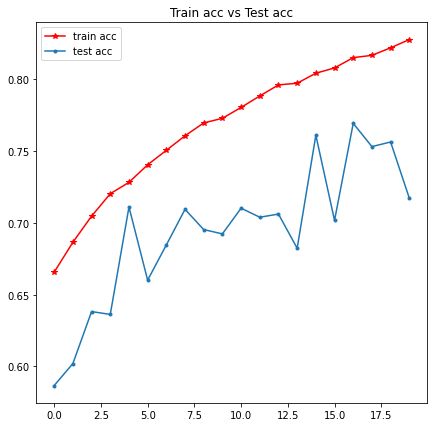

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
plt.plot([x for x in range(epochs)], train_accs, 'r*-', label='train acc')
plt.plot([x for x in range(epochs)], test_accs, '.-', label='test acc')
plt.title("Train acc vs Test acc")
plt.legend()

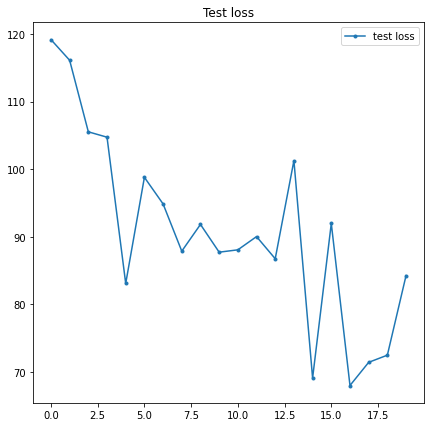

In [129]:
fig2 = plt.figure(figsize=(7, 7))
plt.plot([x for x in range(epochs)], test_losses, '.-', label='test loss')
plt.title("Test loss")
plt.legend()